#### Saenger Marissa

SIO221 HW2



In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm

First, use your code from last week to load in the multi-year records from the Scripps pier.

In [2]:
def load_SIOpier_data(start_yr, end_yr):
    '''
    Function to upload SCOOS data from SIO pier for a given timespan (start_yr to end_yr)
    Inputs:
    start_yr (int) -- year after 2000 (e.g. for 2005, input 5)
    end_yr (int) -- year after 2000 (e.g. for 2016, input 16)
    Note: only works for timespans beginning after 2000. Need to modify if using for data before 2000
    '''
    years = np.arange(start_yr, end_yr+1) # create array of years after 2000 (from start_yr to end_yr inclusive)
    
    years_list = [] # create empty list to store strings of years    
    for year in years: # iterate through years        
        if year < 10:            
            years_list.append('200'+ str(year)) # create strings for 2000-2009 and add to list
        else: 
            years_list.append('20'+str(year)) # create strings for 2010-2099 and add to list

    files = [] # create empty list of files    
    for year in years_list: # iterate over list of years as strings

        # open file for a given year as an xarray dataset        
        ds = xr.open_dataset('http://sccoos.org/thredds/dodsC/autoss/scripps_pier-' + year + '.nc') 
        files.append(ds) # add dataset to 'files' list

    ds_ext = xr.concat(files, dim='time') # concatenate files into one dataset over time dimension

    time_ext = [np.datetime64(ti) for ti in ds_ext.time.data] # convert cftime objects to datetime64 objects
    ds_ext['time'] = time_ext # update 'time' index in dataset to contain the converted time array
    
    return ds_ext 

# Use function to load data from 2005 - 2021 into dataset 'ds'
ds = load_SIOpier_data(5, 21)
ds

<xarray.Dataset>
Dimensions:                     (time: 1799019)
Coordinates:
  * time                        (time) datetime64[ns] 2005-06-16T19:28:47 ......
    lat                         float32 32.87
    lon                         float32 -117.3
    depth                       float32 5.0
Data variables: (12/27)
    temperature                 (time) float32 20.28 20.31 20.34 ... 15.37 15.37
    conductivity                (time) float32 4.617 4.62 4.622 ... 4.144 4.144
    pressure                    (time) float32 4.465 4.507 4.527 ... 2.643 2.509
    salinity                    (time) float32 33.35 33.35 33.35 ... 33.34 33.34
    chlorophyll_raw             (time) float32 9.969e+36 9.969e+36 ... 5.0 5.0
    chlorophyll                 (time) float32 8.1 9.345 9.308 ... 68.05 68.05
    ...                          ...
    aux4                        (time) float32 0.0001 0.0001 0.0001 ... 0.0 0.0
    instrument1                 (time) |S64 b'' b'' b'' b'' ... b'' b'' b'' b''
    instrument2                 (time) |S64 b'' b'' b'' b'' ... b'' b'' b'' b''
    platform1                   (time) |S64 b'' b'' b'' b'' ... b'' b'' b'' b''
    station                     (time) |S64 b'Scripps Pier' ... b'Scripps Pier'
    crs                         (time) float64 9.969e+36 9.969e+36 ... 9.969e+36
Attributes: (12/67)
    comment:                         The Scripps Pier automated shore station...
    platform_vocabulary:             GCMD Earth Science Keywords. Version 8.5
    time_coverage_resolution:        PT1S
    geospatial_vertical_max:         5
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5829
    ...                              ...
    date_issued:                     2017-12-14T19:07:01Z
    time_coverage_start:             2005-06-16T19:28:47Z
    date_metadata_modified:          2017-12-14T19:07:01Z
    DODS.strlen:                     25
    DODS.dimName:                    stationNameLength
    DODS_EXTRA.Unlimited_Dimension:  time

#### 1. Visual evaluation. For both temperature and pressure, plot the records from the two years. Are there obvious discrepancies between the two years? What years are covered? Any other observations?

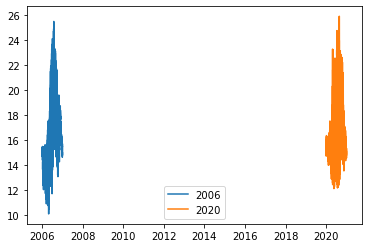

In [3]:
# Try plotting SST in 2006 and in 2020 on the same axis
SST_2006 = ds.sel(time='2006', method='nearest').temperature
SST_2020 = ds.sel(time='2020', method='nearest').temperature

plt.plot(SST_2006.time, SST_2006.values, label='2006');
plt.plot(SST_2020.time, SST_2020.values, label='2020');
plt.legend()

Can't get the time axis to match up since I am comparing values of different years. I don't know how to plot vs time without the year being included in the time values. I want the two time series to overlap over an x axis from January 1 to December 31.

Solution: 
Resample data at the same time frequency to get time series of the same length, and create a new dataset with both years' worth of values stored over a common time period (just for plotting purposes).

This is not a very elegant solution, but I have not yet figured out a better way to deal with this (other than plotting each set of values as a function of time index, which allows me to plot two different years' worth of data over the same x axis, but it is not very useful since we can't see which time index corresponds to which month/season in the axis labels)

In [4]:
# Compare SST and Pressure between 2 different years of sampling

def get_SST_P(ds, yr1, yr2):
    '''
    Function to extract SST and sea water pressure (SWP) data to compare between 2 different years of sampling
    Inputs: 
    ds = dataset containing multiple years' worth of data, including SST and SWP 
    yr1 = string value of a year (e.g. '2002')
    yr2 = string value of another year (e.g. ('2009'))
    '''
    T1 = ds.sel(time = yr1, method='nearest').temperature # save all SST (C) values from yr1 in dataArray 'T1'
    P1 = ds.sel(time = yr1, method='nearest').pressure # save all SWP (dbar) values from yr1 in dataArray 'P1'

    T2 = ds.sel(time = yr2, method='nearest').temperature # same for SST in 2020 
    P2 = ds.sel(time = yr2, method='nearest').pressure # same for sea water pressure in 2020 
    
    return T1, P1, T2, P2 # returns four separate xarray DataArrays 

# Resample to get hourly or daily mean SST value for each year's data
def resample_vals(T1, P1, T2, P2, frequency):
    '''
    Resample data so that each dataArray for each year the same number of time points
    frequency should be input as a string e.g. ('1H' for hourly, '1D' for daily, etc)
    '''

    T1r = T1.resample(time=frequency).mean()
    # T1['time'] = T1.indexes['time'].normalize()

    T2r = T2.resample(time=frequency).mean() 
    # T2['time'] = T2.indexes['time'].normalize()
    
    P1r = P1.resample(time=frequency).mean()
    # P1['time'] = P1.indexes['time'].normalize()

    P2r = P2.resample(time=frequency).mean() 
    # P2['time'] = P2.indexes['time'].normalize()
    
    return T1r, P1r, T2r, P2r # returns dataArrays with 'r' added at the end to denote 'resampled'

# Function for combining the time series into a same-time-axis dataset
# 'hack' because it is kind of a sketchy manipulation of time values and should only be used for plotting
def combine_data_time_hack(T1r, P1r, T2r, P2r, frequency):
    '''
    Combines resampled SST and P time series data from different years into one dataset over the same year 
    so that we can easily plot them on the same time axis. Note that this requires setting the time values 
    for data from one year to the time values of the data for another year which is not correct 
    so this should ONLY be used for visual comparison 
    '''
    ds_combined = xr.Dataset() # Create new dataset to store values from each year over the same time period
    
    # Specify first 365 days of data so that all time series are same length 
    # (e.g. cut off last 24 hr or last day if leap year)
    
    # If resampling was hourly: cut off last 24hr of any leap year
    if frequency == '1H':
        ds_combined['time'] = T1r.time[0:8760] # Set time as hourly resampled time values from yr1 time series
        ds_combined['SST1'] = T1r.values[0:8760] 
        ds_combined['SST2'] = T2r.values[0:8760]
        ds_combined['P1'] = P1r.values[0:8760]
        ds_combined['P2'] = P2r.values[0:8760]
    
    # if resampling was daily: cut off last day of any leap year
    if frequency == '1D':
        ds_combined['time'] = T1r.time[0:365] # Set time as daily resampled time values from yr1 time series
        ds_combined['SST1'] = T1r.values[0:365] 
        ds_combined['SST2'] = T2r.values[0:365] 
        ds_combined['P1'] = P1r.values[0:365] 
        ds_combined['P2'] = P2r.values[0:365] 

    return ds_combined

# Create plot for SST
def SST_compare_plot(ds_combined, yr1, yr2):
    
    plt.figure(figsize=(14,6));
    plt.plot(ds_combined.time, ds_combined.SST1, 'g--', label = yr1);
    plt.plot(ds_combined.time, ds_combined.SST2, 'b--', label = yr2);
    plt.legend();
    plt.xlabel('Month', fontsize=14);
    plt.ylabel('Sea Surface Temperature (ºC)', fontsize=14);
    xticks = [yr1+'-01', yr1+'-02', yr1+'-03', yr1+'-04', yr1+'-05', yr1+'-06', # set x tick for each months 
              yr1+'-07', yr1+'-08', yr1+'-09', yr1+'-10', yr1+'-11', yr1+'-12'];
    xlabels = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'];
    title = ('Sea Surface Temperature at Scripps Pier, La Jolla CA \n' + yr1 + ' vs ' + yr2)
    plt.title(title, fontsize=16);
    plt.xticks(ticks=xticks, labels=xlabels, rotation=20, fontsize=14);
    
# Create plot for sea water pressure
def SWP_compare_plot(ds_combined, yr1, yr2):
    
    plt.figure(figsize=(14,6));
    plt.plot(ds_combined.time, ds_combined.P1, 'g--', label = yr1);
    plt.plot(ds_combined.time, ds_combined.P2, 'b--', label = yr2);
    plt.legend();
    plt.xlabel('Month', fontsize=14);
    plt.ylabel('Sea Water Pressure (dbar)', fontsize=14);
    xticks = [yr1+'-01', yr1+'-02', yr1+'-03', yr1+'-04', yr1+'-05', yr1+'-06',  # set x tick for each month
              yr1+'-07', yr1+'-08', yr1+'-09', yr1+'-10', yr1+'-11', yr1+'-12'];
    xlabels = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'];
    title = ('Sea Water Pressure at Scripps Pier, La Jolla CA \n' + yr1 + ' vs ' + yr2)
    plt.title(title, fontsize=16);
    plt.xticks(ticks=xticks, labels=xlabels, rotation=20, fontsize=14);

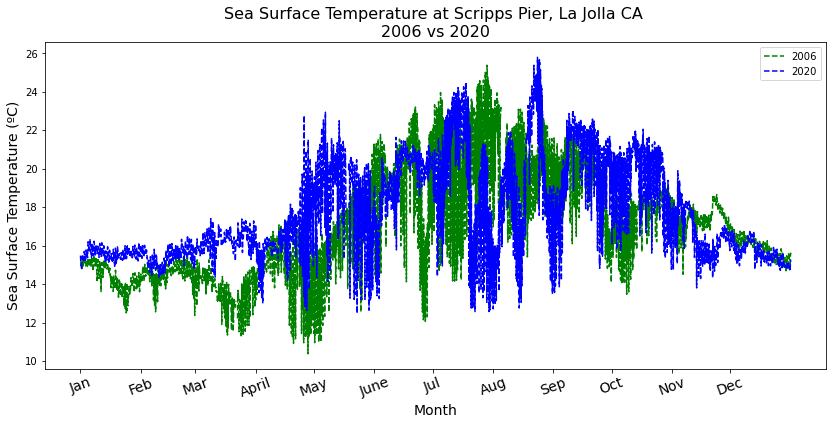

In [5]:
# Use get_SST_P function to store SST and pressure data in variables T1, P1, T2, and P2 for yr1 and yr2
yr1 = '2006'
yr2 = '2020'
T06, P06, T20, P20 = get_SST_P(ds, yr1, yr2)

# Use resample_vals function to store hourly mean resampled data as new variables 
frequency = '1H' # Resample hourly
T06r, P06r, T20r, P20r = resample_vals(T06, P06, T20, P20, frequency)

# Use combine_data_time_hack function to create combined dataset to use for same-time-axis plot comparison
ds_combined = combine_data_time_hack(T06r, P06r, T20r, P20r, frequency)

# Use SST_compare_plot to plot SST in 2006 and 2020 to compare 
SST_compare_plot(ds_combined, yr1, yr2)

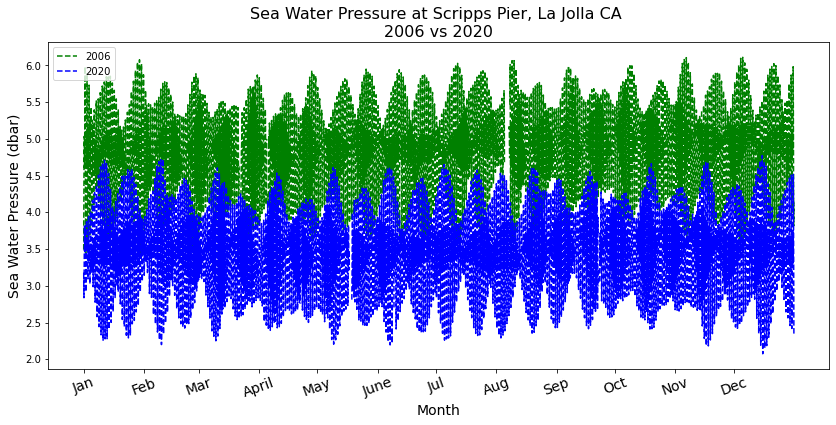

In [6]:
# Use SWP_compare_plot to compare sea water pressure in 2006 and 2020 
SWP_compare_plot(ds_combined, yr1, yr2)

#### 1 (Answer):

I compared the SST and pressure records from the years 2006 and 2020. At first glance, I notice the following:

- SST:

    - Temps are warmer in the first 5 months of the year in 2020 than in 2006, especially in March and May. 
    - In the summer months (JJA), temps go up and down a lot in both years. 
    - In the early fall (Sept-Oct), temps are higher in 2020 than they were in 2006. 
    - In the second half of the year, the 2020 record seems to have more variability than 2006
    - Temps are about the same toward the end of the year in both years (with 2006 a little warmer in Nov than 2020)
    
- Sea water pressure

    - Pressure record is consistently higher on average in 2006 than in 2020! 
    - Both follow a similar pattern of variability (frequency looks like it could be correlated with lunar cycles/tides?)


I don't quite understand why sea water pressure would differ this much between years. I'm curious what happens if I compare sea water pressure between different years. Let's try 2010 and 2014:

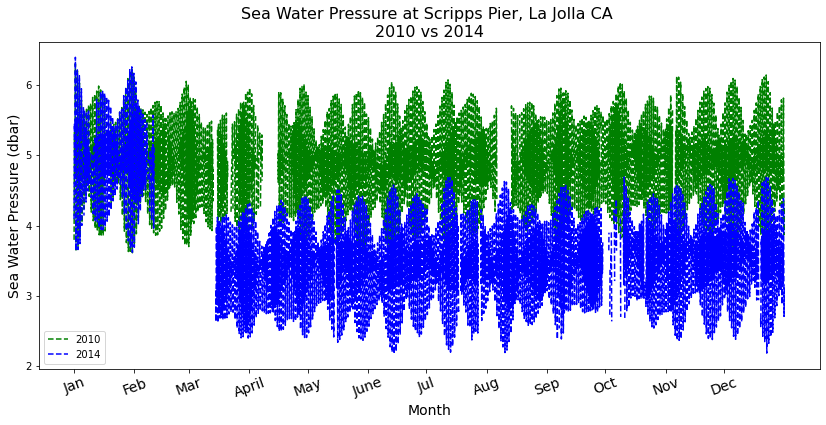

In [7]:
# Use functions above to compare SST and P records from two different years

yr1 = '2010'
yr2 = '2014'
T10, P10, T14, P14 = get_SST_P(ds, yr1, yr2)

frequency = '1H' # Resample hourly
T10r, P10r, T14r, P14r = resample_vals(T10, P10, T14, P14, frequency)

ds_combined = combine_data_time_hack(T10r, P10r, T14r, P14r, frequency)
SWP_compare_plot(ds_combined, yr1, yr2)

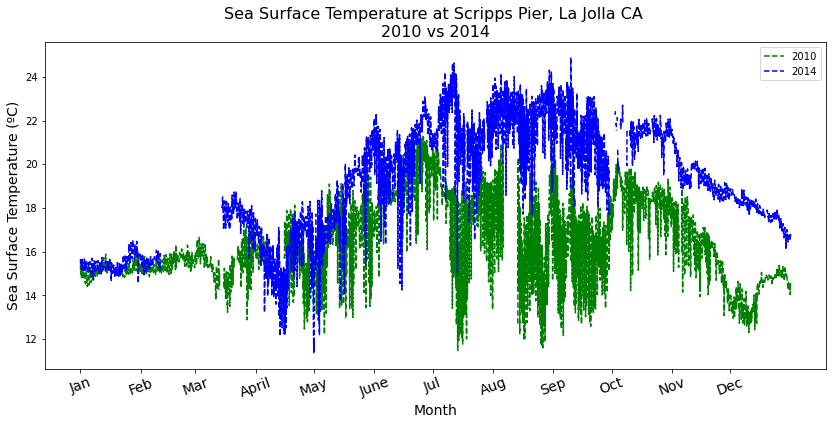

In [8]:
# Look at SST too just out of curiosity

SST_compare_plot(ds_combined, yr1, yr2)

When I compare 2010 and 2014, there is a data gap in Feb-March and interestingly, sea water pressure is about the same between the two years before the gap but is consistently higher for 2010 than 2014 after the gap. Maybe something happened in 2014 that caused a bias in pressure readings after that data gap (that could explain why 2020 shows consistently lower pressure than 2006 in the previous plots). 

Also, SST is consistently higher in 2014 than in 2010.

Try comparing two years after 2014 to each other, and two years before 2014 to each other:

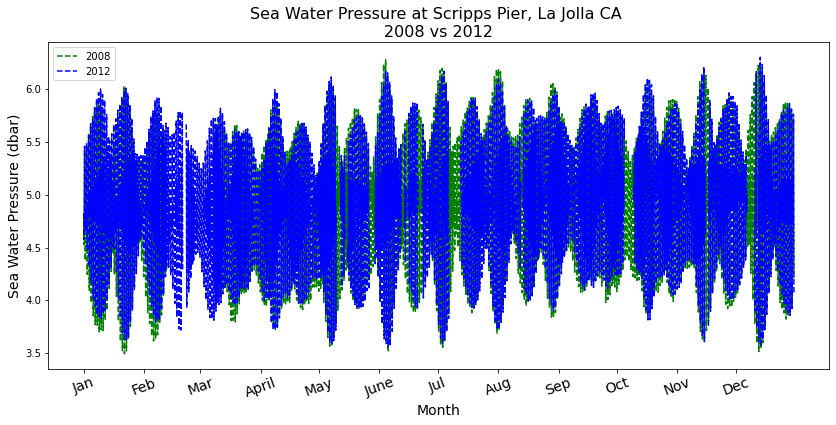

In [9]:
# Use functions above to compare SST and P records from two different years BEFORE 2014

yr1 = '2008'
yr2 = '2012'
T10, P10, T14, P14 = get_SST_P(ds, yr1, yr2)

frequency = '1H' # Resample hourly
T10r, P10r, T14r, P14r = resample_vals(T10, P10, T14, P14, frequency)

ds_combined = combine_data_time_hack(T10r, P10r, T14r, P14r, frequency)
SWP_compare_plot(ds_combined, yr1, yr2)

Sea water pressure values are about the same for each year (and interestingly it fluctuates in the same ways around the same times of each year)

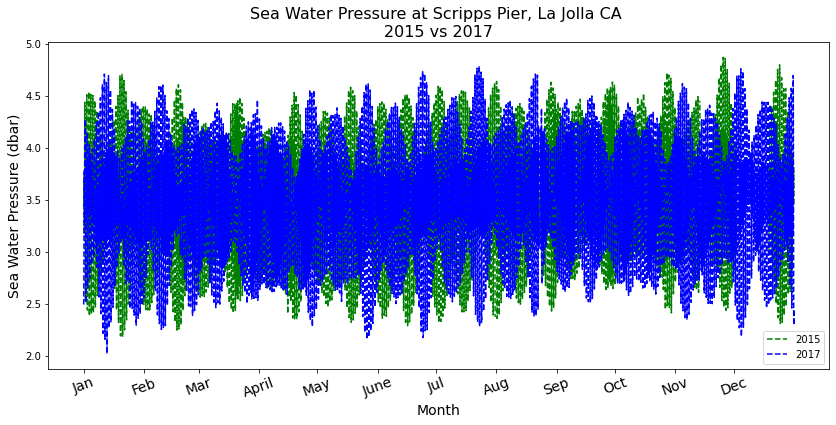

In [10]:
# Now use functions above to compare SST and P records from two different years AFTER 2014

yr1 = '2015'
yr2 = '2017'
T10, P10, T14, P14 = get_SST_P(ds, yr1, yr2)

frequency = '1H' # Resample hourly
T10r, P10r, T14r, P14r = resample_vals(T10, P10, T14, P14, frequency)

ds_combined = combine_data_time_hack(T10r, P10r, T14r, P14r, frequency)
SWP_compare_plot(ds_combined, yr1, yr2)

Here we see that sea water pressure is pretty similar between two different years if the two years compared both fall on the same 'side' of 2014. Let's see what happens if we compare another year before 2014 with a different year after 2014:

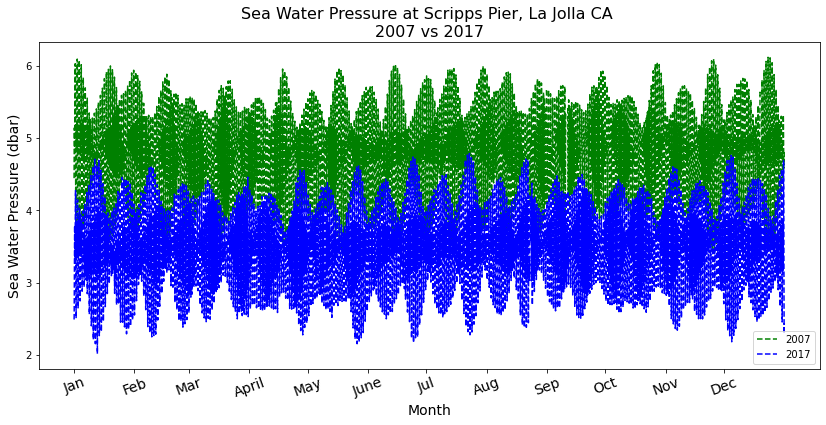

In [11]:
yr1 = '2007'
yr2 = '2017'
T10, P10, T14, P14 = get_SST_P(ds, yr1, yr2)

frequency = '1H' # Resample hourly
T10r, P10r, T14r, P14r = resample_vals(T10, P10, T14, P14, frequency)

ds_combined = combine_data_time_hack(T10r, P10r, T14r, P14r, frequency)
SWP_compare_plot(ds_combined, yr1, yr2)

Here we again see consistently lower sea water pressure values in 2017 than in 2007. It would take more investigation to fully prove or explain this, but it looks like maybe something happened to bias pressure measurements lower after 2014 than they were before. Or could the differences be ENSO-related? I'll leave these questions to someone who has more free time than I do to explore further.

Anyway, let's continue to question 2, using the years 2006 and 2020 which were the first two years I compared before going down this rabbit hole. 

#### 2. Means. For each quantity, evaluate whether the sample mean between the two years is consistent within error bars. Do you obtain different results if you subsample the data at (say) once per day?

In [12]:
# Make functions to speed the process of printing results rounded to a certain number of decimal places
# (just because it requires less typing)

def round2(val):   
    return np.round(val,2) # 2 decimal places

def round3(val):   
    return np.round(val,3) # 3 decimal places

def round4(val):   
    return np.round(val,4) # 4 decimal places

From Lecture 4 notes: standard error of the mean is $\sigma_x=\sigma/\sqrt{N}$, where $\sigma$ is the standard deviation and N is the number of sampling intervals.

In [13]:
# Use get_SST_P function to get SST and pressure data from yr1 and yr2
# (These values are not resampled)

yr1 = '2006'
yr2 = '2020'
T06, P06, T20, P20 = get_SST_P(ds, yr1, yr2)

print('Data sampled every 4 minutes: \n')

N_T06 = len(T06.values) # Number of samples for SST in 2006
N_P06 = len(P06.values) # Number of samples for Pressure in 2006
N_T20 = len(T20.values) # Number of samples for SST in 2020
N_P20 = len(P20.values) # Number of samples for Pressure in 2020

std_T06 = T06.std(dim='time').values # Calculate standard deviation for SST in 2006
std_P06 = P06.std(dim='time').values # same for pressure
std_T20 = T20.std(dim='time').values # same for SST, 2020
std_P20 = P20.std(dim='time').values # same for pressure, 2020

# Calculate standard error of the mean for SST, 2006
mean_stderror_T06 = std_T06/np.sqrt(N_T06)

print('Mean SST in 2006:', np.round(T06.mean(dim='time').values,2), '+/-', 
      np.round(mean_stderror_T06,4), 'ºC')

# Calculate standard error of the mean for SST, 2020
mean_stderror_T20 = std_T20/np.sqrt(N_T20)

print('Mean SST in 2020:', np.round(T20.mean(dim='time').values,2), 
      '+/-', np.round(mean_stderror_T20,4), 'ºC')

# Calculate standard error of the mean for Pressure, 2006
mean_stderror_P06 = std_P06/np.sqrt(N_P06)

print(' \nMean Sea Water Pressure in 2006:', 
      np.round(P06.mean(dim='time').values,2), 
      '+/-', np.round(mean_stderror_P06,4), 'dbar')

# Calculate standard error of the mean for Pressure, 2020
mean_stderror_P20 = std_P20/np.sqrt(N_P20)

print('Mean Sea Water Pressure in 2020:', 
      np.round(P20.mean(dim='time').values,2), 
      '+/-', np.round(mean_stderror_P20,4), 'dbar')

Data sampled every 4 minutes: 

Mean SST in 2006: 17.04 +/- 0.0079 ºC
Mean SST in 2020: 17.75 +/- 0.0071 ºC
 
Mean Sea Water Pressure in 2006: 4.83 +/- 0.0014 dbar
Mean Sea Water Pressure in 2020: 3.46 +/- 0.0014 dbar


The sample mean between the two years is not consistent within error bars; the sample mean values for each quantity in 2020 do not fall within the error bars of the sample mean values for the same quantity in 2006 (and vice versa). 

Let's see if this changes if we subsample the data daily:

In [14]:
# Use resample_vals function to store daily mean resampled data as new variables 
    # with 'r' added at the end to denote 'resampled'

frequency = '1D' # Resample daily
T06r, P06r, T20r, P20r = resample_vals(T06, P06, T20, P20, frequency)

N_T06r = len(T06r.values) # Number of samples for SST in 2006
N_P06r = len(P06r.values) # Number of samples for Pressure in 2006
N_T20r = len(T20r.values) # Number of samples for SST in 2020
N_P20r = len(P20r.values) # Number of samples for Pressure in 2020

std_T06r = T06r.std(dim='time').values # Calculate standard deviation for SST in 2006
std_P06r = P06r.std(dim='time').values # same for pressure
std_T20r = T20r.std(dim='time').values # same for SST, 2020
std_P20r = P20r.std(dim='time').values # same for pressure, 2020

print('Data subsampled once per day: \n')

# Calculate standard error of the mean for SST, 2006 (resampled once daily)
mean_stderror_T06r = std_T06r/np.sqrt(N_T06r)

print('Mean SST in 2006:', 
      round2(T06r.mean(dim='time').values), 
      '+/-', round4(mean_stderror_T06r), 'ºC')

# Calculate standard error of the mean for SST, 2020
mean_stderror_T20r = std_T20r/np.sqrt(N_T20r)

print('Mean SST in 2020:', round2(T20r.mean(dim='time').values), 
      '+/-', round4(mean_stderror_T20r), 'ºC')

# Calculate standard error of the mean for Pressure, 2006
mean_stderror_P06r = std_P06r/np.sqrt(N_P06r)

print(' \nMean Sea Water Pressure in 2006:', 
      round2(P06r.mean(dim='time').values), 
      '+/-', round4(mean_stderror_P06r), 'dbar')

# Calculate standard error of the mean for Pressure, 2020
mean_stderror_P20r = std_P20r/np.sqrt(N_P20r)

print('Mean Sea Water Pressure in 2020:', 
      round2(P20r.mean(dim='time').values), 
      '+/-', round4(mean_stderror_P20r), 'dbar')

Data subsampled once per day: 

Mean SST in 2006: 17.09 +/- 0.1341 ºC
Mean SST in 2020: 17.77 +/- 0.122 ºC
 
Mean Sea Water Pressure in 2006: 4.83 +/- 0.0043 dbar
Mean Sea Water Pressure in 2020: 3.46 +/- 0.0029 dbar


Even when we repeat the calculations for data that has been subsampled daily (thereby dramatically reducing N), the sample mean between the two different years is not consistent within error bars; although the error bars do stretch further from the mean values for each quantity, the sample mean values for each quantity in 2020 do not fall within the error bars of the sample mean values for the same quantity in 2006 (and vice versa). 

#### 3. Variance. For each quantity, evaluate whether the variance from the two years are consistent. Do you obtain different results if you subsample the data at (say) once per day?

Variance = $\sigma^{2}$

From lecture 4 notes: standard error of the variance = $\sigma^2\sqrt{2/(N-1)}$

In [15]:
# Function to calculate standard error of the variance 
def calc_stderr_variance(sigma, N):
    stderr_var = (sigma**2)*np.sqrt(2/(N-1))
    return stderr_var

In [16]:
# Calculate the variance and standard error of the variance for original data sampled 
# every 4 min (aka not resampled)

# use previously calculated sigma values to calculate variance
var_T06 = std_T06**2
var_T20 = std_T20**2
var_P06 = std_P06**2
var_P20 = std_P20**2

# use calc_stderr_variance function to calculate standard error of the variance for each quantity in each year
stderr_var_T06 = calc_stderr_variance(std_T06, N_T06)
stderr_var_T20 = calc_stderr_variance(std_T20, N_T20)
stderr_var_P06 = calc_stderr_variance(std_P06, N_P06)
stderr_var_P20 = calc_stderr_variance(std_P20, N_P20)

print('Data sampled every 4min: \n')

print('2006 SST: variance = ', round3(var_T06), '+/-', round3(stderr_var_T06))
print('2020 SST: variance = ', round3(var_T20), '+/-', round3(stderr_var_T20))

print('\n2006 sea water pressure: variance = ', round3(var_P06), '+/-', round3(stderr_var_P06))
print('2020 sea water pressure: variance = ', round3(var_P20), '+/-', round3(stderr_var_P20))

Data sampled every 4min: 

2006 SST: variance =  7.81 +/- 0.031
2020 SST: variance =  6.512 +/- 0.025

2006 sea water pressure: variance =  0.259 +/- 0.001
2020 sea water pressure: variance =  0.253 +/- 0.001


The variance from the two years are not consistent: the values of the variance between the two years do not fall within error bars of each other for either quantity (SST or sea water pressure).

Let's see if this changes for the same data sampled once per day:

In [17]:
# Calculate the variance and standard error of the variance for data subsampled once per day.
    # We already have values for standard deviation of the mean for the daily subsampled data from calculations above.
    # Now we can just calculate the variance and standard error of the variance for the daily subsampled data:

# use previously calculated sigma values to calculate variance
var_T06r = std_T06r**2
var_T20r = std_T20r**2
var_P06r = std_P06r**2
var_P20r = std_P20r**2

# use calc_stderr_variance function to calculate standard error of the variance for each quantity in each year
stderr_var_T06r = calc_stderr_variance(std_T06r, N_T06r)
stderr_var_T20r = calc_stderr_variance(std_T20r, N_T20r)
stderr_var_P06r = calc_stderr_variance(std_P06r, N_P06r)
stderr_var_P20r = calc_stderr_variance(std_P20r, N_P20r)

print('Data subsampled once per day: \n')

print('2006 SST: variance = ', round3(var_T06r), '+/-', round3(stderr_var_T06r))
print('2020 SST: variance = ', round3(var_T20r), '+/-', round3(stderr_var_T20r))

print('\n2006 sea water pressure: variance = ', round4(var_P06r), '+/-', round4(stderr_var_P06r))
print('2020 sea water pressure: variance = ', round4(var_P20r), '+/-', round4(stderr_var_P20r))

Data subsampled once per day: 

2006 SST: variance =  6.566 +/- 0.487
2020 SST: variance =  5.451 +/- 0.404

2006 sea water pressure: variance =  0.0067 +/- 0.0005
2020 sea water pressure: variance =  0.003 +/- 0.0002


The values for variance become smaller and the standard error of the variance becomes larger if the data is subsampled at a lower frequency / fewer points. However, the values of the variance between the two years still do not fall within error bars of each other, therefore the variance values from the two years are still not consistent (although I am not 100% sure if this is what 'consistent' means?)

#### 4. Extreme values. For each of the two years, compute the likelihood given the observed PDF, and a Gaussian PDF with the observed variance, of a temperature extreme value 3σ greater than the mean.

In [18]:
# Function to plot observed pdf

def plot_pdf(yr, data, var):    
    '''
    yr = string (e.g. '2008')
    data = dataArray containing pressure/SST data (e.g. T06, P20r, etc)
    var = string ('SST' or 'Sea Water Pressure')
    '''
    std = data.std(dim='time').values
    sig3_higher = np.mean(data.values) + 3*std

    plt.figure(figsize=(12,6))
    # plt.hist(data.values, bins=100, histtype='step', density=True, label='PDF', linewidth='2');
    norm_hist, bins = np.histogram(data.values, bins=500, density=True)
    bins = bins[:-1]
    dbins = bins[1]-bins[0]
    plt.plot(bins, norm_hist)

    if var == 'SST':
        plt.xlabel('Sea Surface Temperature (ºC)', fontsize=14);
    if var == 'Sea Water Pressure':
        plt.xlabel('Sea Water Pressure (dbar)', fontsize=14)
    plt.ylabel('Probability Density', fontsize=14);
    plt.title('Probability Density Function \n' +  yr + ' ' + var + ' at SIO Pier', fontsize=16);

    # Add a vertical line for the mean SST value and dotted lines for values 1, 2, and 3 sigma from the mean

    plt.axvline(np.mean(data.values), color='g', label='Mean '+var)
    plt.axvline(np.mean(data.values) + std, color='lightseagreen', linestyle='--', label='1 \u03C3')
    plt.axvline(np.mean(data.values) + 2*std, color='skyblue', linestyle='--', label='2 \u03C3')
    plt.axvline(sig3_higher, color='tomato', linestyle='--', label='3 \u03C3')

    plt.axvline(np.mean(data.values) - std, color='lightseagreen', linestyle='--')
    plt.axvline(np.mean(data.values) - 2*std, color='skyblue', linestyle='--')
    plt.axvline(np.mean(data.values) - 3*std, color='tomato', linestyle='--')
    plt.legend()
    
    if var == 'SST':
        print('Value 3 \u03C3 greater than the mean:', round3(sig3_higher), 'ºC')
    if var == 'Sea Water Pressure':
        print('Value 3 \u03C3 greater than the mean:', round3(sig3_higher), 'dbar')
    idx = np.argwhere(np.isclose(bins, sig3_higher, atol=(0.5*dbins)))
    if idx.size > 0:
        print('Probability: ', format(float(norm_hist[idx]), '.2e'))
    else: print('Probability = 0')

Value 3 σ greater than the mean: 25.424 ºC
Probability:  1.05e-03


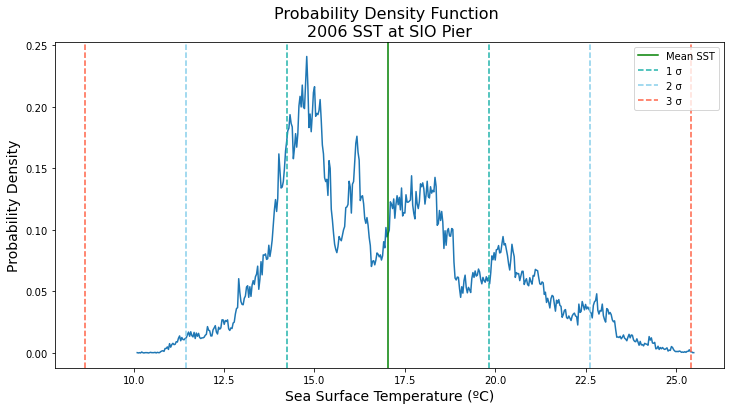

In [19]:
plot_pdf('2006', T06, 'SST')

Value 3 σ greater than the mean: 25.408 ºC
Probability:  2.78e-03


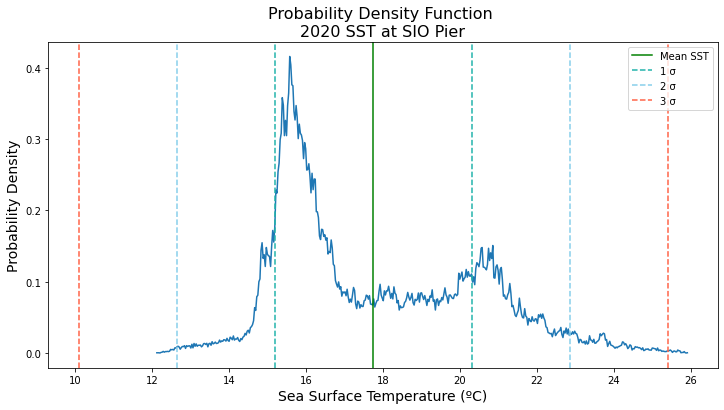

In [20]:
yr = '2020'; data = T20; var = 'SST'
plot_pdf(yr, data, var)

Plot Gaussian PDF with the observed variance and calculate probability of a SST extreme 3sigma above the mean.

From Lecture 3 notes, Gaussian distribution:
$$
p(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)\hspace{3cm} (5)
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation.

In [21]:
# Use compute_histogram from Lecture 3 Notes

def compute_histogram(data, bin_max, bin_min, dbin, pdf=False):
    
    """ Computes 1D histogram or probability density for a given variable.
    
    Keyword arguments:
    data -- 1D array.
    bin_max -- maximum value for bins
    bin_min -- minimum value for bins
    dbin -- bin size
    pdf -- (default False)
    
    Returns:
    bins -- histogram bins
    counts -- either counts or probability density  
    """
    bins = np.arange(bin_min, bin_max, dbin)
    count = []
    
    for i in range(len(bins)):
        ind = (data>bins[i] - dbin/2) & (data<=bins[i]+dbin/2)
        count.append(ind.sum())
        
    count = np.array(count)
    
    if pdf:
        norm_hist = count/count.sum()/dbin
        
        # The statement following 'assert' must be true otherwise it will return an error
        # (https://realpython.com/python-assert-statement/)
        assert np.allclose(norm_hist.sum()*dbin, 1.0), "PDF doesn't sum to 1" 
    
        return bins, norm_hist
    
    else:
        return bins, count    

In [42]:
def plot_gauss_pdf(data, var, yr):
    
    sig = np.std(data.values)
    mu = np.mean(data.values)
    sig3_higher = mu + 3*sig
    dbin=0.1
    bins, norm_hist = compute_histogram(data=data, bin_max=data.values.max()+sig,
                                        bin_min=data.values.min()-sig, dbin=dbin, pdf=True)

    sig = np.std(data.values)
    mu = np.mean(data.values)
    sig3_higher = mu + 3*sig
    gaus = (1.0/sig/np.sqrt(2*np.pi)) * (np.exp(-(bins-mu)**2 / (2*sig**2)))

    plt.figure(figsize=(12, 6))
    plt.plot(bins, norm_hist, 'b', lw=2, label='Data')
    plt.plot(bins, gaus, 'k', lw=2, label='Gaussian')
    plt.xlabel('Pressure [dbar]', fontsize=14);
    plt.ylabel('Probability density',  fontsize=14);

    plt.axvline(mu, color='g', label='Mean '+var)
    plt.axvline(mu + sig, color='lightseagreen', linestyle='--', label='1 \u03C3')
    plt.axvline(mu + 2*sig, color='skyblue', linestyle='--', label='2 \u03C3')
    plt.axvline(mu + 3*sig, color='tomato', linestyle='--', label='3 \u03C3')

    plt.axvline(mu - sig, color='lightseagreen', linestyle='--')
    plt.axvline(mu - 2*sig, color='skyblue', linestyle='--')
    plt.axvline(mu - 3*sig, color='tomato', linestyle='--')
    plt.legend()

    if var == 'SST': print('Mean=', round3(mu), 'ºC;  \u03C3=', round3(sig),' ºC')
    if var == 'Sea Water Pressure': print('Mean=', round3(mu), 'dbar;  \u03C3=',round3(sig),'dbar')
    # print('\u03C3: ', round3(sig))
    # print('variance: ', round3(sig**2))

    if var == 'SST':
        print('Value 3 \u03C3 greater than the mean:', round3(sig3_higher), 'ºC')
    if var == 'Sea Water Pressure':
        print('Value 3 \u03C3 greater than the mean:', round3(sig3_higher), 'dbar')
    idx = np.argwhere(np.isclose(bins, sig3_higher, atol=(0.5*dbin)))
    if idx.size > 0:
        print('Probability (if Gaussian): ', format(float(gaus[idx]), '.2e'))
    else: print('Probability (if Gaussian) = 0')
        
    if var == 'SST':
        plt.xlabel('Sea Surface Temperature (ºC)', fontsize=14);
    if var == 'Sea Water Pressure':
        plt.xlabel('Sea Water Pressure (dbar)', fontsize=14)
    plt.ylabel('Probability Density', fontsize=14);
    plt.title('Probability Density Function \n' +  yr + ' ' + var + ' at SIO Pier', fontsize=16);

Mean= 17.04 ºC;  σ= 2.795  ºC
Value 3 σ greater than the mean: 25.424 ºC
Probability (if Gaussian):  1.62e-03


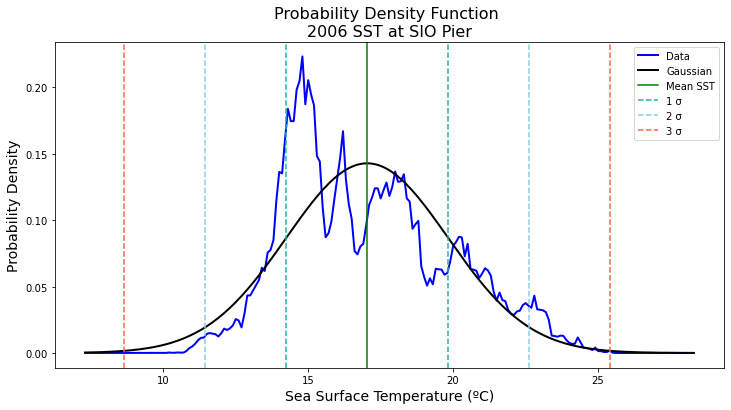

In [43]:
# SST, 2006: plot data and Gaussian pdf
plot_gauss_pdf(data=T06, var='SST', yr='2006')

Mean= 17.753 ºC;  σ= 2.552  ºC
Value 3 σ greater than the mean: 25.408 ºC
Probability (if Gaussian):  1.80e-03


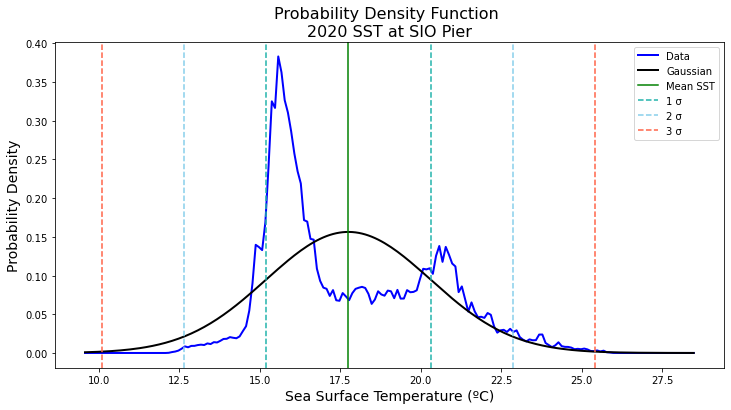

In [44]:
# SST, 2020: plot data and Gaussian pdf
plot_gauss_pdf(data=T20, var='SST', yr='2020')

#### 5. Probability density functions. For both pressure and temperature, plot the pdfs for the two years on the same axes. Overplot the Gaussian and uniform distributions that have the observed mean and variance.

Mean= 4.832 dbar;  σ= 0.509 dbar
Value 3 σ greater than the mean: 6.36 dbar
Probability (if Gaussian):  8.43e-03


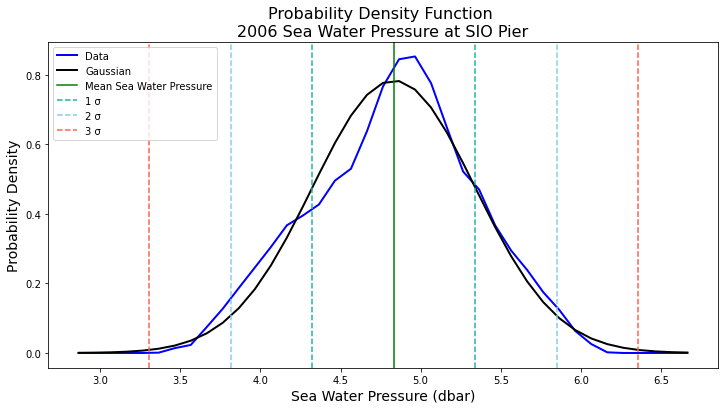

In [45]:
plot_gauss_pdf(data=P06, var='Sea Water Pressure', yr='2006')

Mean= 3.465 dbar;  σ= 0.503 dbar
Value 3 σ greater than the mean: 4.975 dbar
Probability (if Gaussian):  8.66e-03


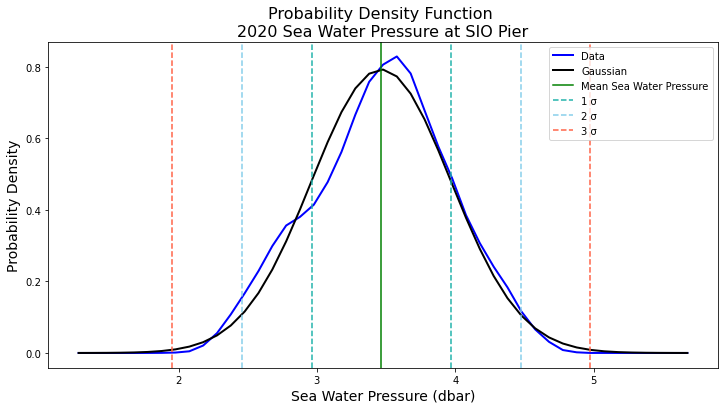

In [46]:
plot_gauss_pdf(data=P20, var='Sea Water Pressure', yr='2020')

Plot a uniform distribution with the mean and variance as our data using a system of equations for a uniform distribution between a and b where:

$$ \small \mu = \frac{1}{2}(a+b) $$ 
$$ \small \sigma^{2} = \frac{1}{12}(b-a)^{2} $$ 

solving for a and b:

$$ \small a = \mu - \frac{\sqrt{12}\sigma}{2} = \mu - \sigma\sqrt{3} $$ 

$$ \small b = 2\mu - \frac{\sqrt{12}\sigma}{2} = \sqrt{3}\sigma + \mu $$ 

In [85]:
## Use the a and b values calculated using the method above to create a uniform distribution of random 
# variables with the same mean and variance as our data

def plot_all(data1, data2, name, yr1, yr2, dbin=0.1):
    
    
    sig1 = np.std(data1.values)
    var1 = sig1**2
    mu1 = np.mean(data1.values)
    
    sig2 = np.std(data2.values)
    var2 = sig2**2
    mu2 = np.mean(data2.values)
    
    # compute (observed) pdf for each years' worth of data
    bins1, norm_hist1 = compute_histogram(data=data1, bin_max=data1.values.max(),
                                          bin_min=data1.values.min(), dbin=dbin, pdf=True)
    bins2, norm_hist2 = compute_histogram(data=data2, bin_max=data2.values.max(),
                                          bin_min=data2.values.min(), dbin=dbin, pdf=True)

    # compute (hypothetical) Gaussian pdf for each years' worth of data 
    gaus1 = (1.0/sig1/np.sqrt(2*np.pi)) * (np.exp(-(bins1-mu1)**2 / (2*sig1**2)))
    gaus2 = (1.0/sig2/np.sqrt(2*np.pi)) * (np.exp(-(bins2-mu2)**2 / (2*sig2**2)))

    plt.figure(figsize=(12, 8))
    
    plt.plot(bins1, norm_hist1, 'darkcyan', lw=2, label='Data' + yr1)
    plt.plot(bins2, norm_hist2, 'seagreen', lw=2, label='Data' + yr2)
    
    plt.plot(bins1, gaus1, 'dimgray', lw=2, label='Gaussian' + yr1)
    plt.plot(bins2, gaus2, 'black', lw=2, label='Gaussian' + yr2)
        
    # Create (hypothetical) uniform distribution for each years' worth of data 
    a1 = mu1 - sig1*np.sqrt(3)
    b1 = np.sqrt(3)*sig1 + mu1
    
    a2 = mu2 - sig2*np.sqrt(3)
    b2 = np.sqrt(3)*sig2 + mu2

    uni_dist1 = np.random.uniform(a1,b1,len(data1.values))
    uni_dist2 = np.random.uniform(a2,b2,len(data2.values))

    bins1, uniform1 = compute_histogram(data=uni_dist1, bin_max=data1.max(),
                                            bin_min=data1.min(), dbin=0.1, pdf=True)
    bins2, uniform2 = compute_histogram(data=uni_dist2, bin_max=data2.max(),
                                            bin_min=data2.min(), dbin=0.1, pdf=True)

    plt.plot(bins1, uniform1, 'darkmagenta', lw=2, label='Uniform Distribution' + yr1)
    plt.plot(bins2, uniform2, 'magenta', lw=2, label='Uniform Distribution' + yr2)
    
    
    plt.legend()
        
    if name == 'SST':
        plt.xlabel('Sea Surface Temperature (ºC)', fontsize=14);
    if name == 'Sea Water Pressure':
        plt.xlabel('Sea Water Pressure (dbar)', fontsize=14)
        
    plt.ylabel('Probability Density', fontsize=14);

    plt.title('Probability Density Function \n' +  yr + ' ' + name + ' at SIO Pier', fontsize=16);
    
    

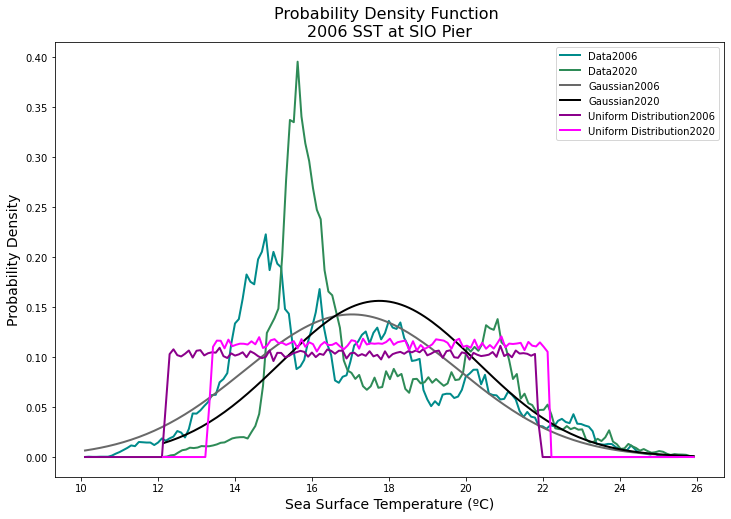

In [86]:
plot_all(data1=T06, data2=T20, name='SST', yr1='2006', yr2='2020')

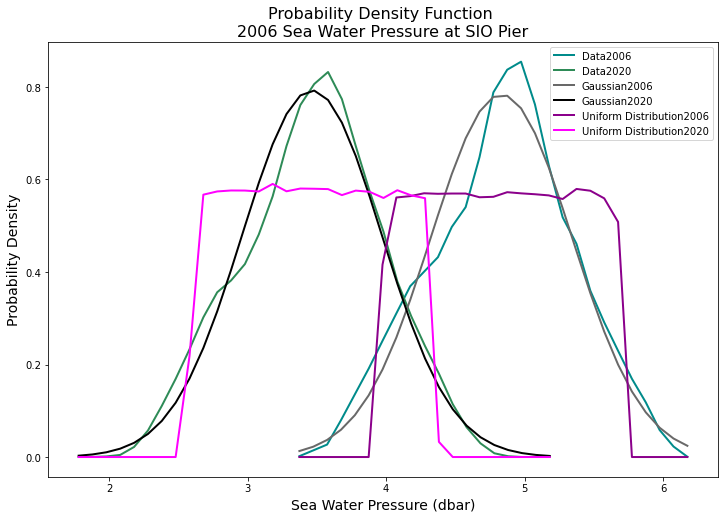

In [87]:
plot_all(data1=P06, data2=P20, name='Sea Water Pressure', yr1='2006', yr2='2020')